### Derive simulation-ready climate forcing for DEMENTpy across Southern California gradient

By Bin Wang (ORNL|UC Irvine|@bioatmo_sphere|wbwenwu@gmail.com)

22/09/2021
- - -

Field transplant (Glassman et al. 2018 PNAS) started in October 2015, so data starting in 2016 are used.

**Method**:

- **data source**: daily data from DAYMET: https://daymet.ornl.gov/web_services
- **derivation of water potential**:build a simple linear regression model with the grassland site data, and use this model learnt to derive water potential for different sites in any years. https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares
- **NOTE**: the subalpine site water potential corrected for frozen water, which in fact is equivalent to high drought pressure.

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
from sklearn import linear_model

print("pandas version:", pd.__version__)
print('numpy version:',  np.__version__)
print('matplotlib version:',  matplotlib.__version__)
print('scikit-learn version:',  sklearn.__version__)

pandas version: 1.2.2
numpy version: 1.19.2
matplotlib version: 3.3.4
scikit-learn version: 0.24.2


## Build a linear model with DEMENT default input data at Loma Ridge

In [3]:
#################### grassland site daily precipitation data from 2011-2013 from DAYMET
grassland_201113 = pd.read_csv('daymet/grassland_201113.csv',skiprows=7)
grassland_201113.head()

year  yday  prcp (mm/day)
0  2011     1           0.00
1  2011     2          10.84
2  2011     3           5.28
3  2011     4           0.00
4  2011     5           0.00

In [4]:
grassland_201113.shape

(1095, 3)

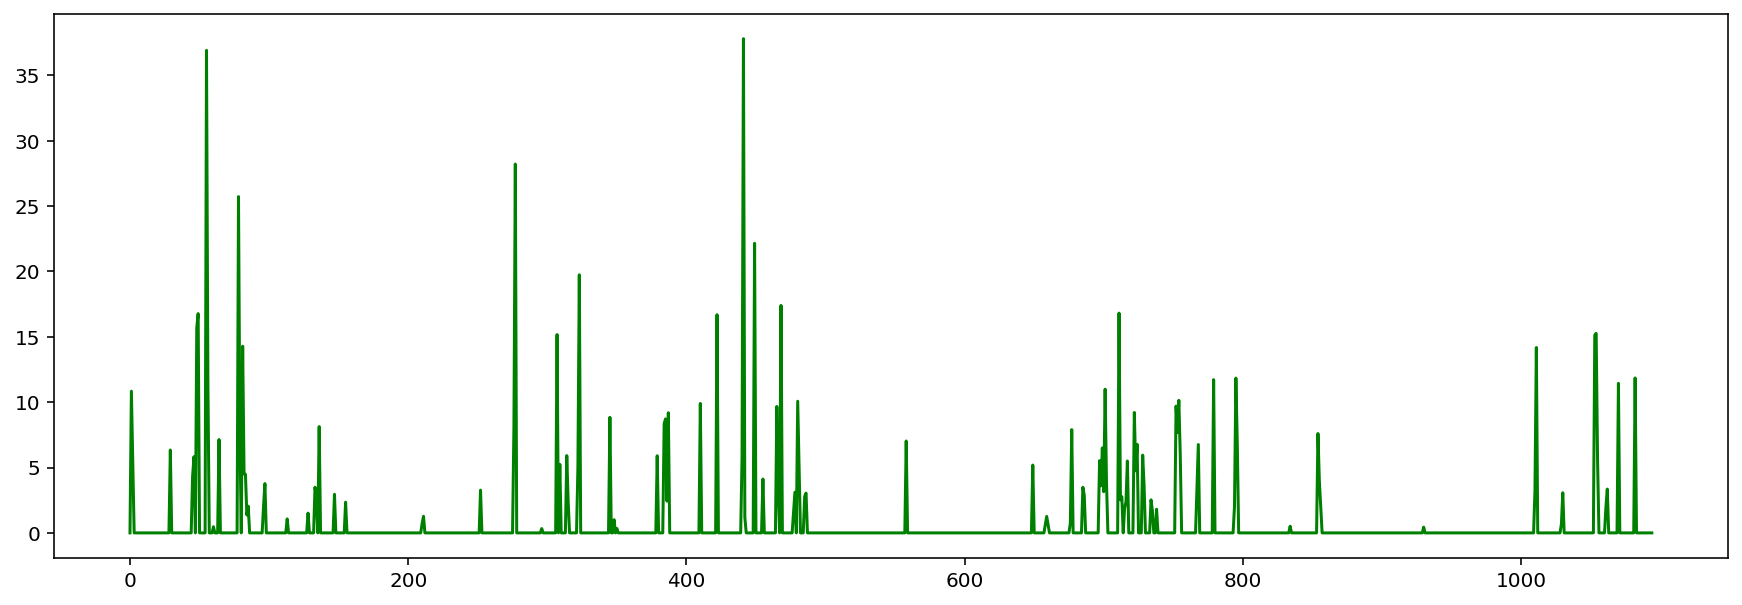

In [5]:
#plot precip
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(grassland_201113.iloc[:,2],c='green')
plt.show()

In [6]:
#DEMENT default input
grassland_psi = pd.read_csv('precipitation/climate_v0.csv')
grassland_psi = grassland_psi.iloc[18:]
grassland_psi

Temp         FM       Psi      Date
18     7.798333  70.563052 -0.484272    1/2/11
19     9.124427  69.616844 -0.491783    1/3/11
20    10.333771  70.026281 -0.488506    1/4/11
21    12.563375  70.557927 -0.484312    1/5/11
22    15.823708  70.375969 -0.485740    1/6/11
...         ...        ...       ...       ...
1108   8.562635  70.940125 -0.481339  12/27/13
1109  10.260396  70.886385 -0.481755  12/28/13
1110   8.514437  70.760833 -0.482729  12/29/13
1111   6.926729  70.928510 -0.481428  12/30/13
1112   6.764208  70.833635 -0.482164  12/31/13

[1095 rows x 4 columns]

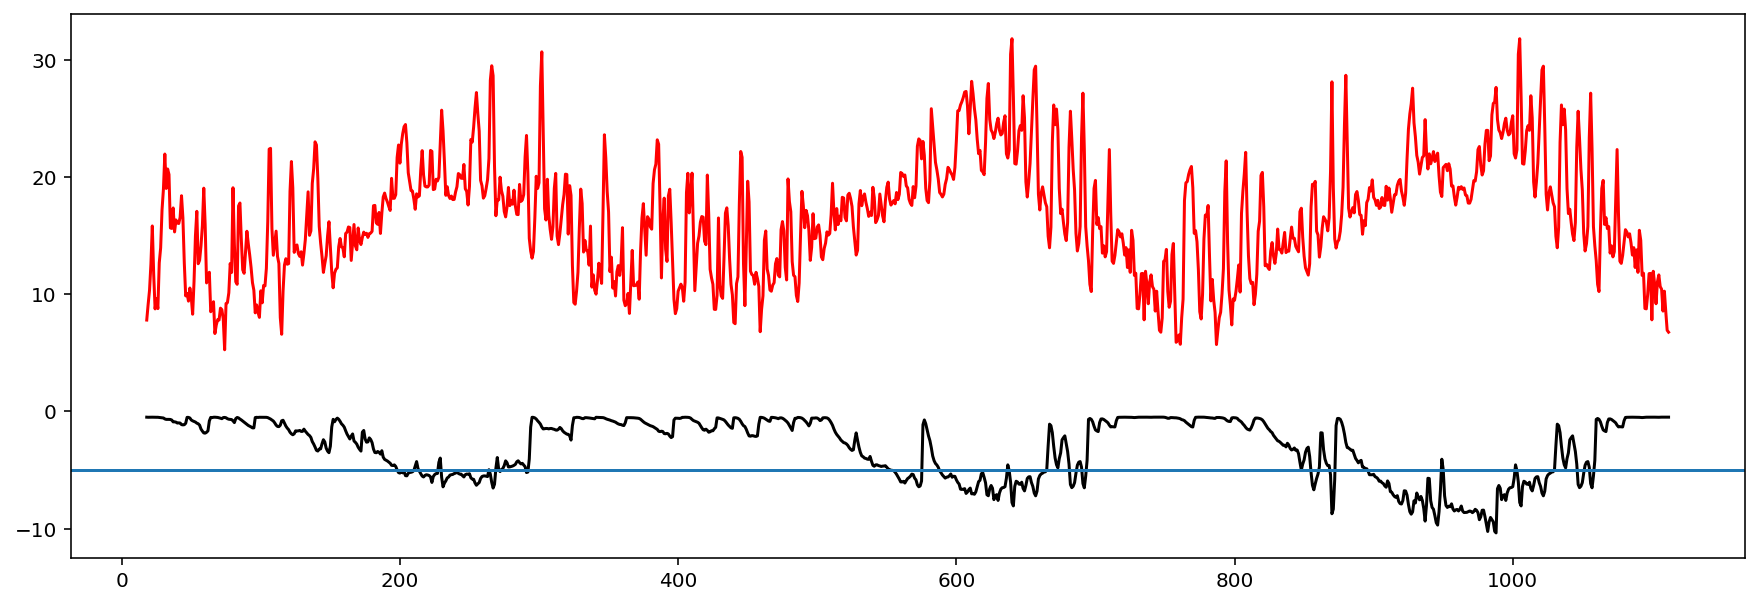

In [7]:
#plot daily temp and litter water potential
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(grassland_psi.loc[:,'Psi'], c='k')
ax.plot(grassland_psi.loc[:,'Temp'],c='r')
ax.axhline(y=-5)

plt.show()

In [8]:
max_psi = grassland_psi.loc[:,'Psi'].max()
max_psi

-0.481271706

In [9]:
#### Pool temp, potential and precip together
temp_prcp = np.zeros([1095,2])
temp_prcp[:,0] = grassland_psi['Temp']
temp_prcp[:,1] = grassland_201113.iloc[:,2]
temp_prcp

array([[ 7.79833333,  0.        ],
       [ 9.12442708, 10.84      ],
       [10.33377083,  5.28      ],
       ...,
       [ 8.5144375 ,  0.        ],
       [ 6.92672917,  0.        ],
       [ 6.76420833,  0.        ]])

In [10]:
## linear model as a function of temp and precipitation
reg = linear_model.LinearRegression()
reg.fit(temp_prcp,grassland_psi['Psi'])

LinearRegression()

In [11]:
reg.coef_

array([-0.37223211,  0.01476186])

In [12]:
reg.intercept_

3.1095518292612754

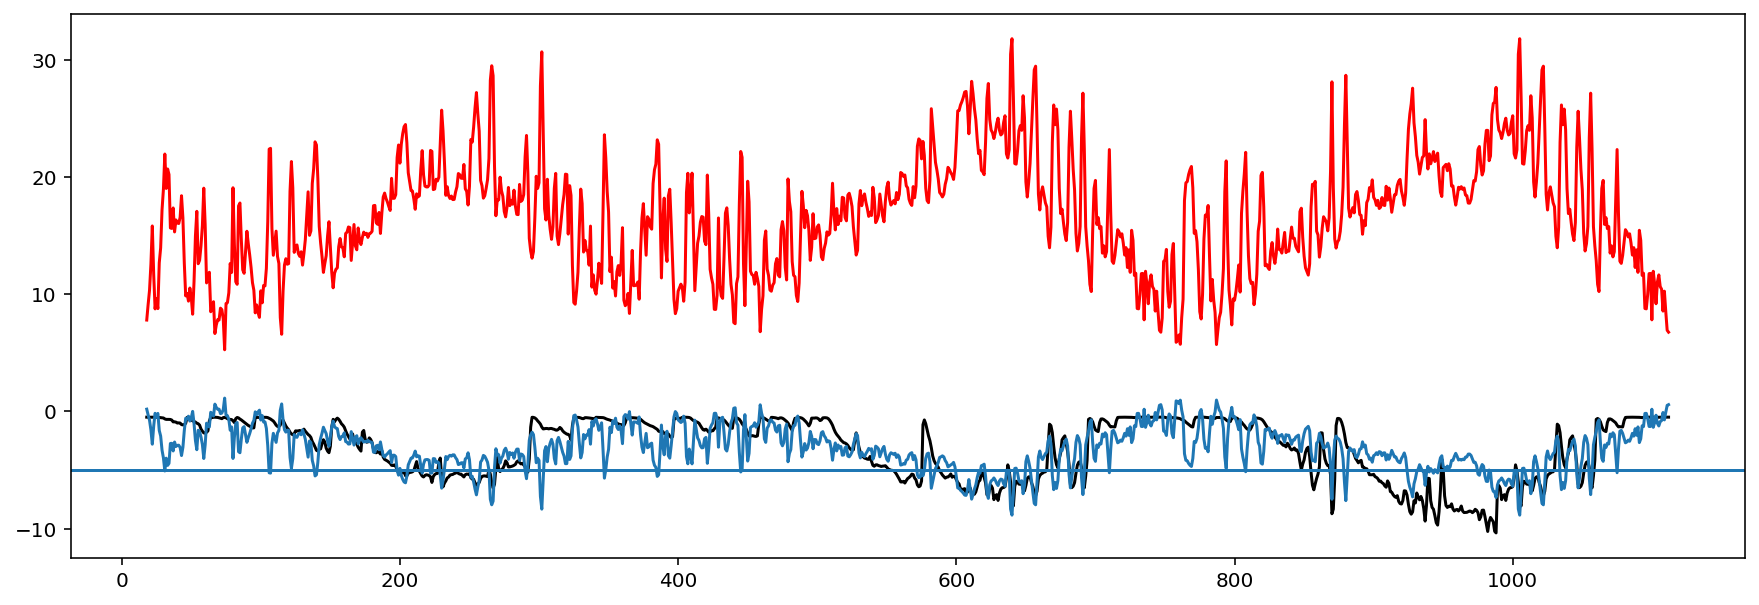

In [13]:
#plot daily temp and litter water potential
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(grassland_psi.loc[:,'Psi'], c='k')
ax.plot(grassland_psi.loc[:,'Temp']*reg.coef_[0] + grassland_psi.loc[:,'Psi']*reg.coef_[1] + reg.intercept_)
ax.plot(grassland_psi.loc[:,'Temp'],c='r')
ax.axhline(y=-5)

plt.show()

## Download DAYMET data (2015-2019) (but only year 2016-19 used)

- reference: https://github.com/ornldaac/daymet-single-pixel-batch/blob/master/python/daymet_multiple_extraction.py
- bash script: https://github.com/ornldaac/daymet-single-pixel-batch/tree/master/bash

data derived:desert.csv,scrubland.csv,grassland.csv,pineoak.csv,subalpine.csv

In [14]:
desert    = pd.read_csv('daymet/desert.csv',skiprows=7).iloc[365:,:]
scrubland = pd.read_csv('daymet/scrubland.csv',skiprows=7).iloc[365:,:]
grassland = pd.read_csv('daymet/grassland.csv',skiprows=7).iloc[365:,:]
pineoak   = pd.read_csv('daymet/pineoak.csv',skiprows=7).iloc[365:,:]
subalpine = pd.read_csv('daymet/subalpine.csv',skiprows=7).iloc[365:,:]

desert.head()

year  yday  prcp (mm/day)  tmax (deg c)  tmin (deg c)
365  2016     1           0.00         15.36          1.24
366  2016     2           0.00         17.33          1.48
367  2016     3           0.00         18.02          4.97
368  2016     4           0.00         14.71          8.03
369  2016     5          23.22         11.80          7.75

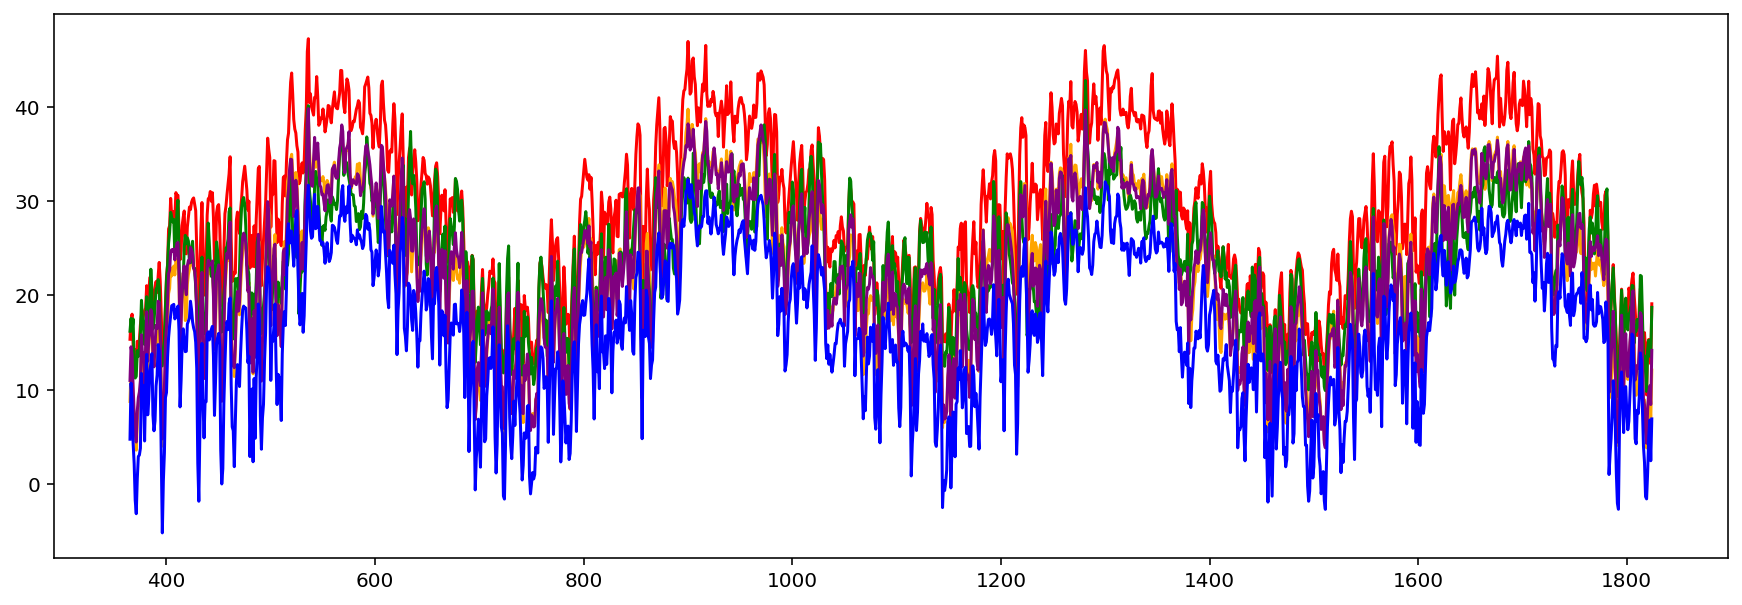

In [15]:
#plot max temp
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(desert.iloc[:,3],c='red')
ax.plot(scrubland.iloc[:,3],c='orange')
ax.plot(grassland.iloc[:,3],c='green')
ax.plot(pineoak.iloc[:,3],c='purple')
ax.plot(subalpine.iloc[:,3],c='blue')

plt.show()

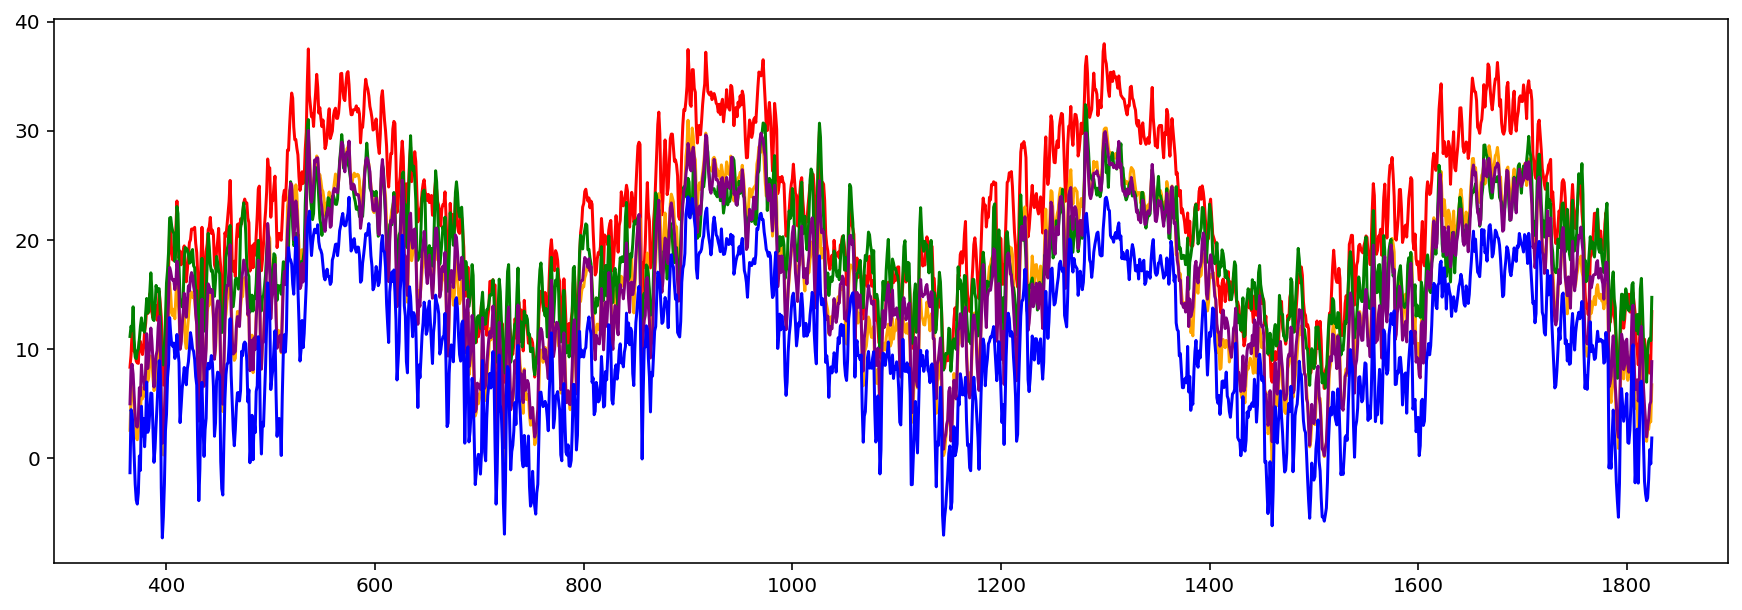

In [16]:
#plot mean temp
desert_temp    = desert.iloc[:,3:5].mean(axis=1)
scrubland_temp = scrubland.iloc[:,3:5].mean(axis=1)
grassland_temp = grassland.iloc[:,3:5].mean(axis=1)
pineoak_temp   = pineoak.iloc[:,3:5].mean(axis=1)
subalpine_temp = subalpine.iloc[:,3:5].mean(axis=1)

fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(desert_temp,     c='red')
ax.plot(scrubland_temp,  c='orange')
ax.plot(grassland_temp,  c='green')
ax.plot(pineoak_temp,    c='purple')
ax.plot(subalpine_temp,  c='blue')

plt.show()

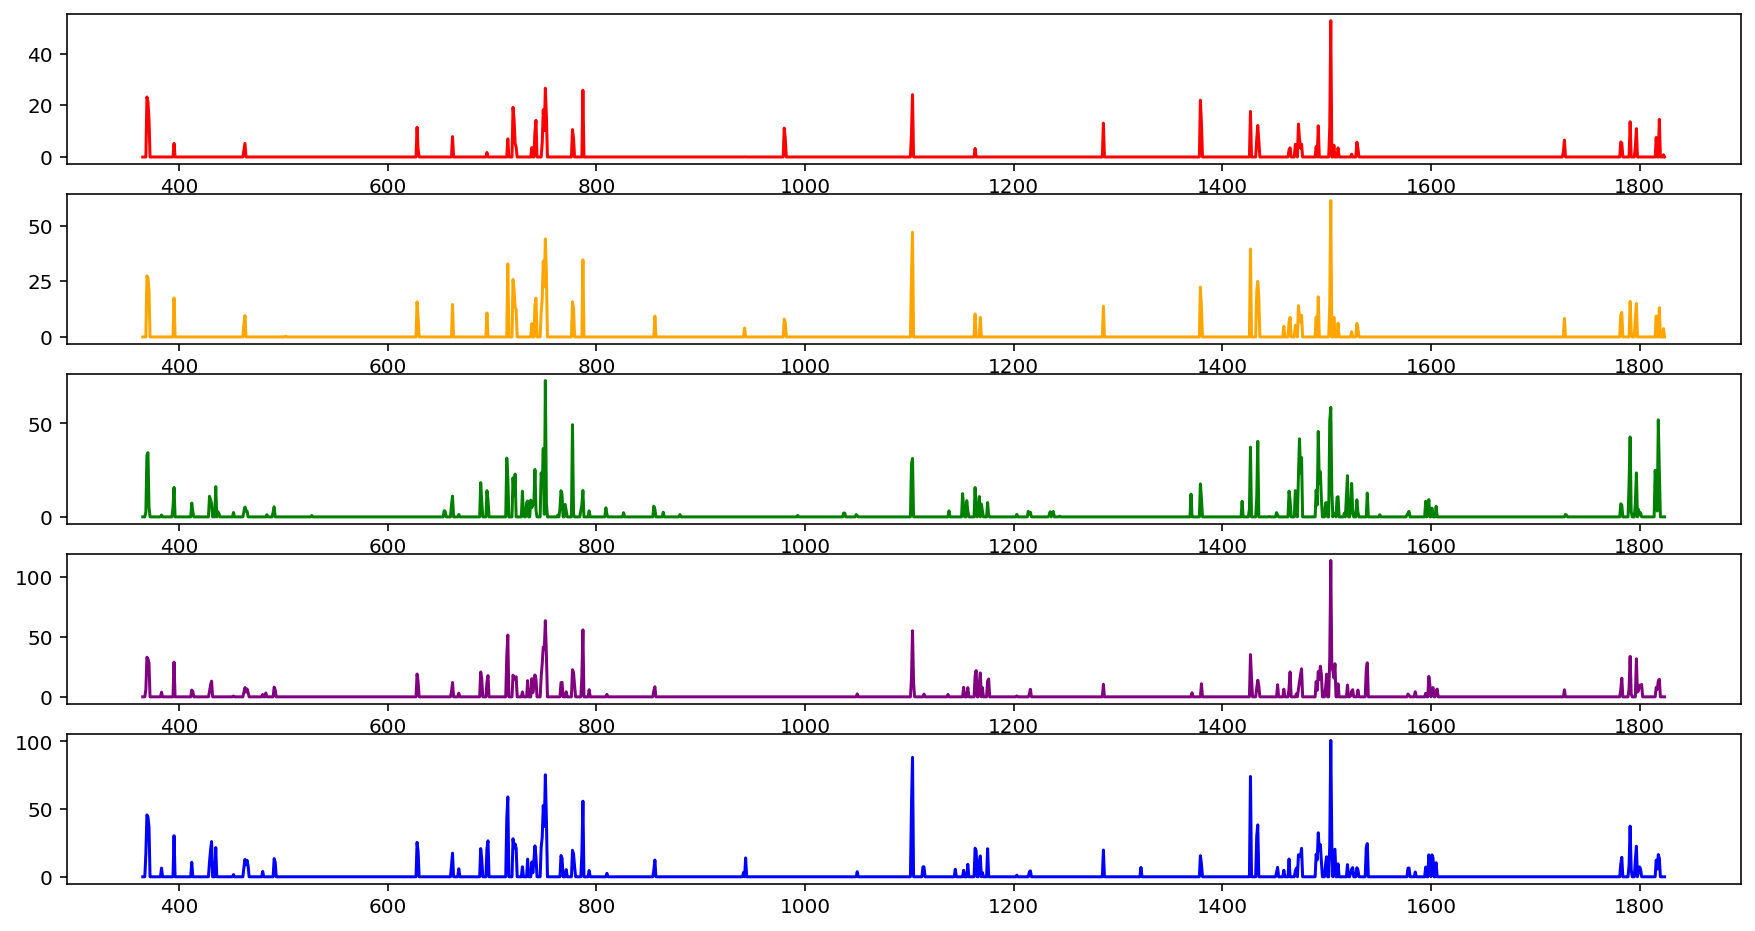

In [17]:
# plot precipitation
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(15,8))
ax1.plot(desert.iloc[:,2],   c='red')
ax2.plot(scrubland.iloc[:,2],c='orange')
ax3.plot(grassland.iloc[:,2],c='green')
ax4.plot(pineoak.iloc[:,2],  c='purple')
ax5.plot(subalpine.iloc[:,2],c='blue')
plt.show()

### data of 2015

In [18]:
desert2015    = pd.read_csv('daymet/desert.csv',skiprows=7).iloc[0:365,]
scrubland2015 = pd.read_csv('daymet/scrubland.csv',skiprows=7).iloc[0:365,:]
grassland2015 = pd.read_csv('daymet/grassland.csv',skiprows=7).iloc[0:365,:]
pineoak2015   = pd.read_csv('daymet/pineoak.csv',skiprows=7).iloc[0:365,:]
subalpine2015 = pd.read_csv('daymet/subalpine.csv',skiprows=7).iloc[0:365:,:]

desert2015.head()

year  yday  prcp (mm/day)  tmax (deg c)  tmin (deg c)
0  2015     1            0.0         11.29         -3.38
1  2015     2            0.0         14.98         -2.60
2  2015     3            0.0         15.04         -0.85
3  2015     4            0.0         17.87          1.17
4  2015     5            0.0         22.56          3.76

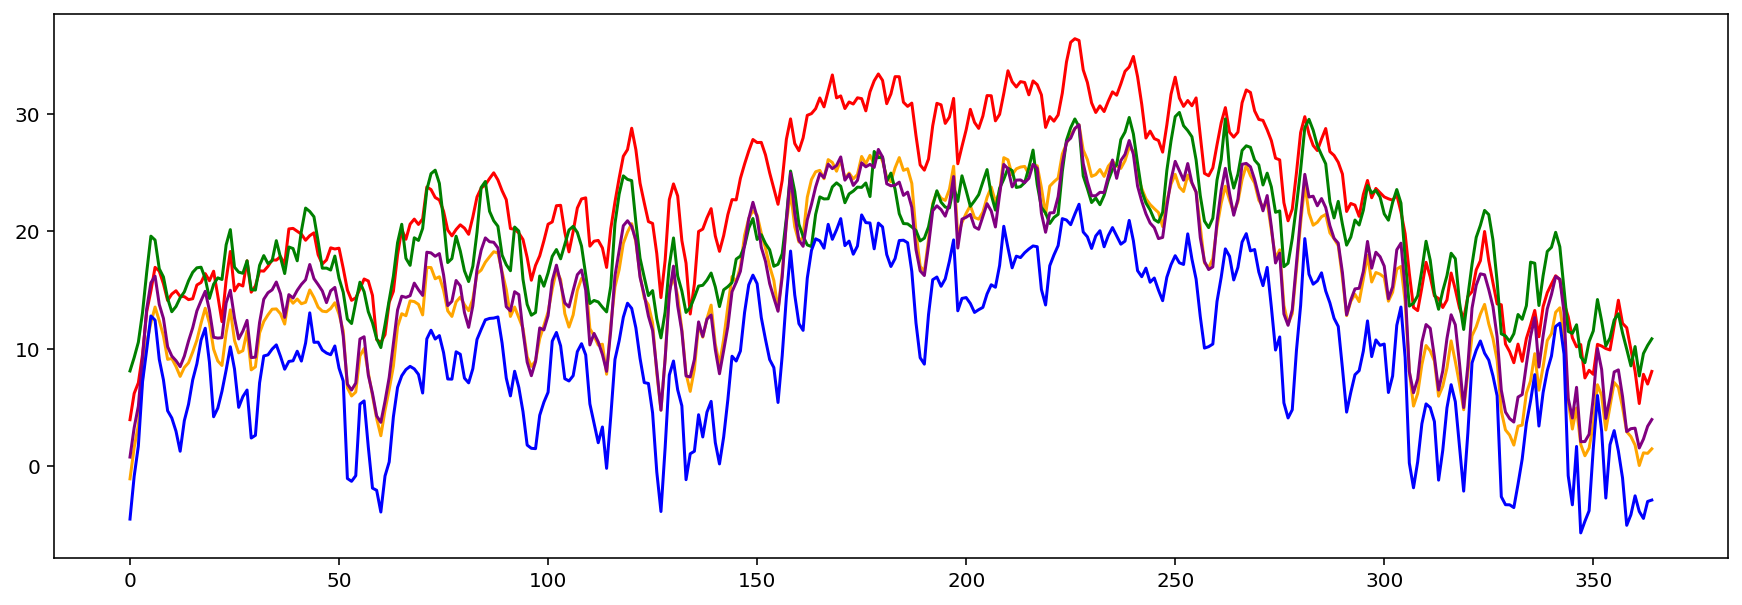

In [19]:
#plot mean temp
desert2015_temp    = desert2015.iloc[:,3:5].mean(axis=1)
scrubland2015_temp = scrubland2015.iloc[:,3:5].mean(axis=1)
grassland2015_temp = grassland2015.iloc[:,3:5].mean(axis=1)
pineoak2015_temp   = pineoak2015.iloc[:,3:5].mean(axis=1)
subalpine2015_temp = subalpine2015.iloc[:,3:5].mean(axis=1)

fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(desert2015_temp,     c='red')
ax.plot(scrubland2015_temp,  c='orange')
ax.plot(grassland2015_temp,  c='green')
ax.plot(pineoak2015_temp,    c='purple')
ax.plot(subalpine2015_temp,  c='blue')

plt.show()

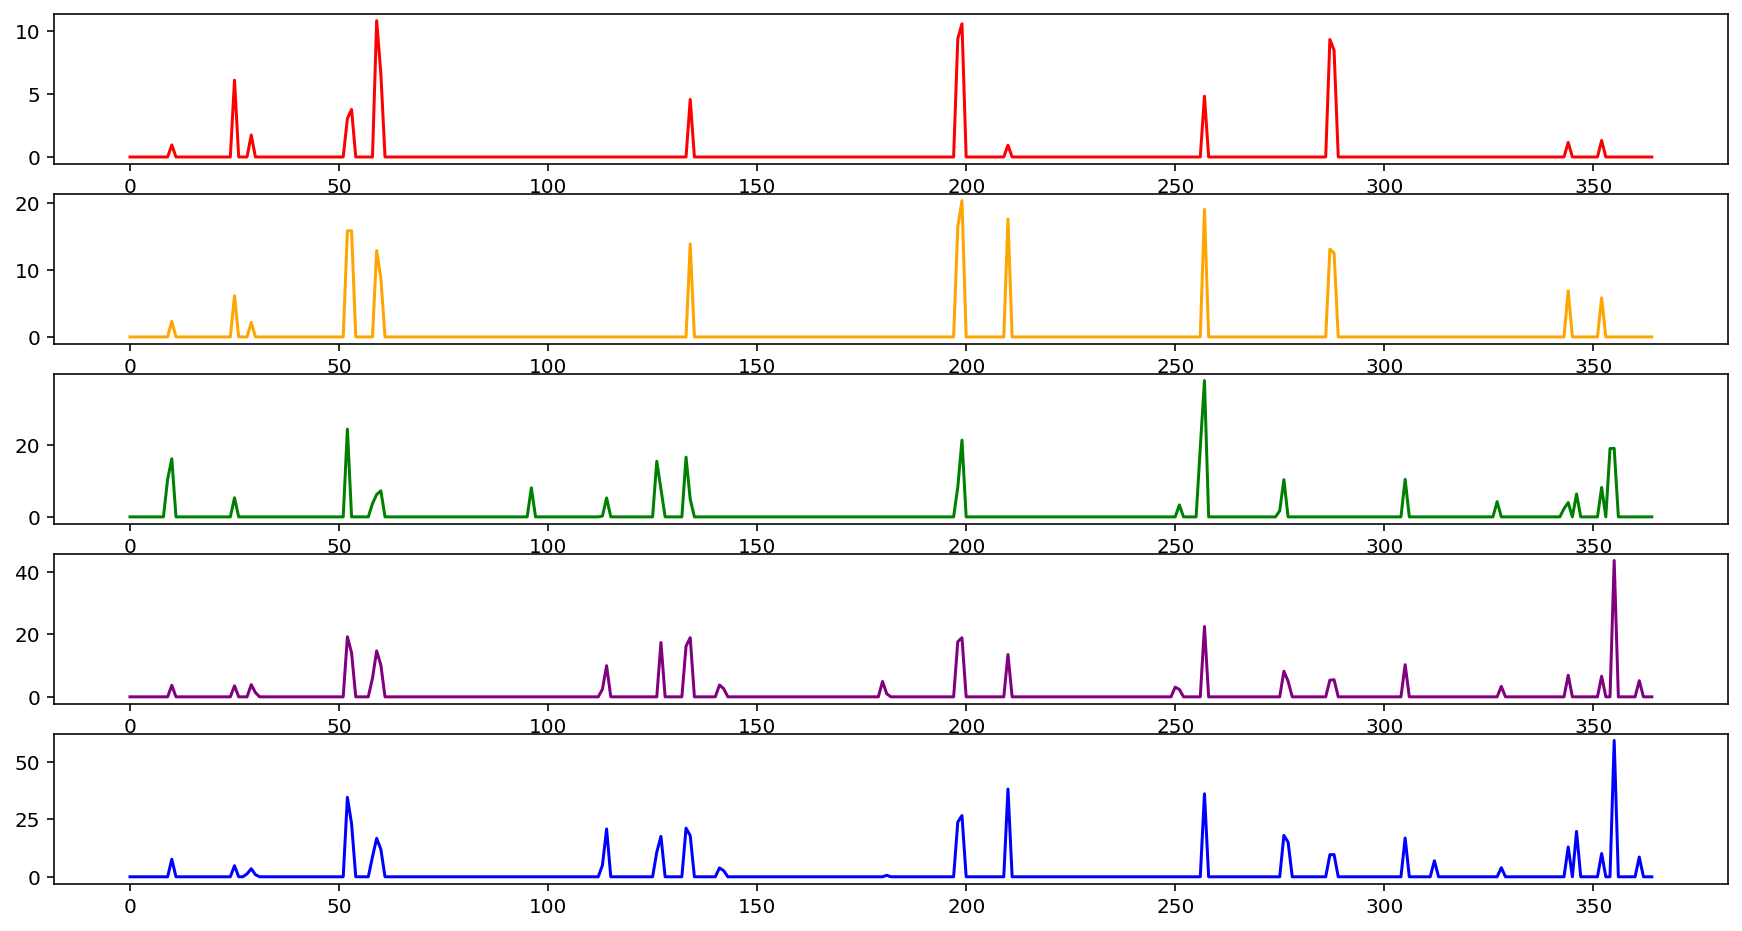

In [20]:
# plot precipitation
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(15,8))
ax1.plot(desert2015.iloc[:,2],   c='red')
ax2.plot(scrubland2015.iloc[:,2],c='orange')
ax3.plot(grassland2015.iloc[:,2],c='green')
ax4.plot(pineoak2015.iloc[:,2],  c='purple')
ax5.plot(subalpine2015.iloc[:,2],c='blue')
plt.show()

## Apply the linear model learnt to derive water potential by site

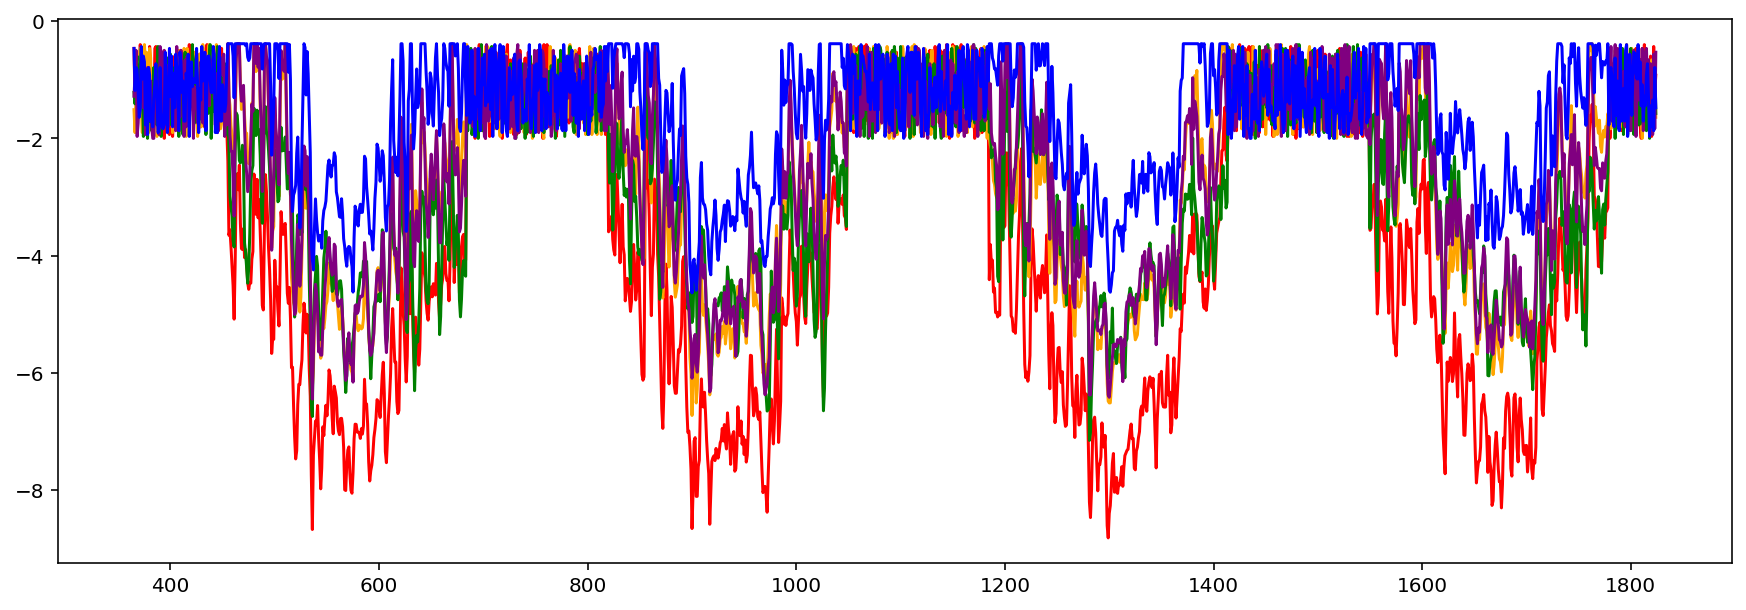

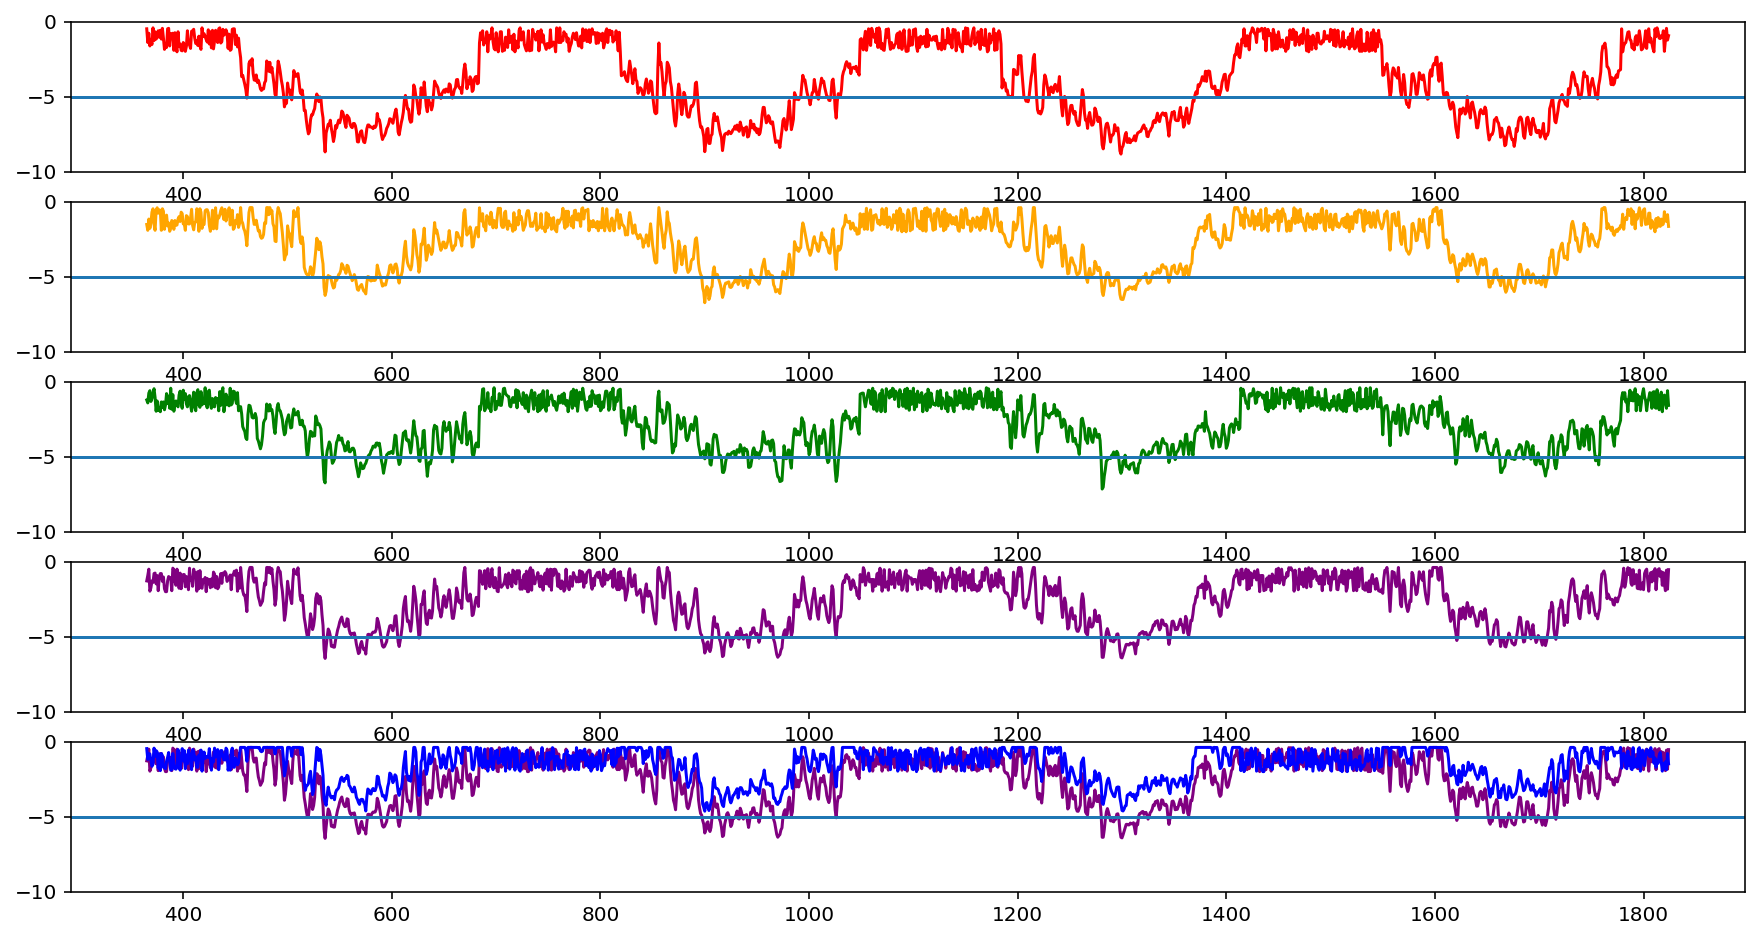

In [21]:
np.random.seed(1234)

# get site-specific water potential 
desert_psi    = reg.intercept_ + desert.iloc[:,3:5].mean(axis=1)    * reg.coef_[0] + desert.iloc[:,2]    * reg.coef_[1]
scrubland_psi = reg.intercept_ + scrubland.iloc[:,3:5].mean(axis=1) * reg.coef_[0] + scrubland.iloc[:,2] * reg.coef_[1]
grassland_psi = reg.intercept_ + grassland.iloc[:,3:5].mean(axis=1) * reg.coef_[0] + grassland.iloc[:,2] * reg.coef_[1]
pineoak_psi   = reg.intercept_ + pineoak.iloc[:,3:5].mean(axis=1)   * reg.coef_[0] + pineoak.iloc[:,2]   * reg.coef_[1]
subalpine_psi = reg.intercept_ + subalpine.iloc[:,3:5].mean(axis=1) * reg.coef_[0] + subalpine.iloc[:,2] * reg.coef_[1]
#subalpine_psi = subalpine_psi*0.8

desert_psi[desert_psi>max_psi]       = max_psi
scrubland_psi[scrubland_psi>max_psi] = max_psi
grassland_psi[grassland_psi>max_psi] = max_psi
pineoak_psi[pineoak_psi>max_psi]     = max_psi
subalpine_psi[subalpine_psi>max_psi] = max_psi

desert_psi    = desert_psi*0.8
scrubland_psi = scrubland_psi*0.8
grassland_psi = grassland_psi*0.8
pineoak_psi   = pineoak_psi*0.8
subalpine_psi = subalpine_psi*0.8

de=90
desert_psi[0*365:0*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
desert_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
desert_psi[1*365:1*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
desert_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
desert_psi[2*365:2*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
desert_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
desert_psi[3*365:3*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
desert_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)

sc=90
scrubland_psi[0*365:0*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
scrubland_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
scrubland_psi[1*365:1*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
scrubland_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
scrubland_psi[2*365:2*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
scrubland_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
scrubland_psi[3*365:3*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
scrubland_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)

gr=90
grassland_psi[0*365:0*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
grassland_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
grassland_psi[1*365:1*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
grassland_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
grassland_psi[2*365:2*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
grassland_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
grassland_psi[3*365:3*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
grassland_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)


pi=90
pineoak_psi[0*365:0*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
pineoak_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
pineoak_psi[1*365:1*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
pineoak_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
pineoak_psi[2*365:2*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
pineoak_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
pineoak_psi[3*365:3*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
pineoak_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)

su=90
subalpine_psi[0*365:0*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
subalpine_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
subalpine_psi[1*365:1*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
subalpine_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
subalpine_psi[2*365:2*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
subalpine_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
subalpine_psi[3*365:3*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
subalpine_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)


fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(desert_psi,   c='red')
ax.plot(scrubland_psi,c='orange')
ax.plot(grassland_psi,c='green')
ax.plot(pineoak_psi,  c='purple')
ax.plot(subalpine_psi,c='blue')


fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(15,8))
ax1.plot(desert_psi,   c='red')
ax1.set_ylim(-10,0)
ax1.axhline(y=-5)

ax2.plot(scrubland_psi,c='orange')
ax2.set_ylim(-10,0)
ax2.axhline(y=-5)

ax3.plot(grassland_psi,c='green')
ax3.set_ylim(-10,0)
ax3.axhline(y=-5)

ax4.plot(pineoak_psi,  c='purple')
ax4.set_ylim(-10,0)
ax4.axhline(y=-5)

ax5.plot(pineoak_psi,  c='purple')
ax5.plot(subalpine_psi,c='blue')
ax5.set_ylim(-10,0)
ax5.axhline(y=-5)

plt.show()

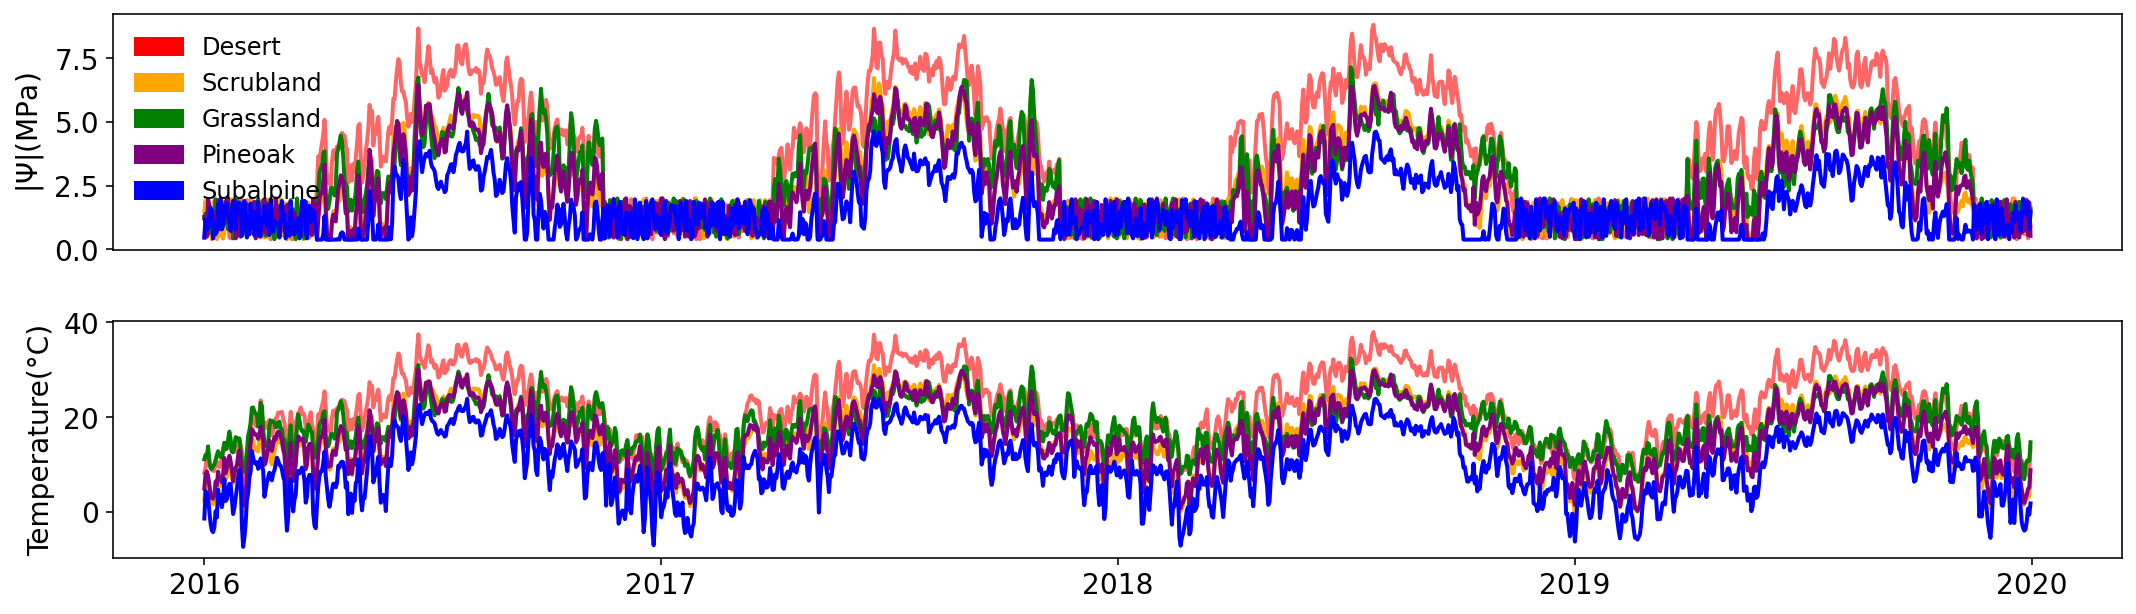

In [22]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,5))

#months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan']
# months = ['Jan', 'Mar', 'May', 'Jul',  'Sep',  'Nov', 'Jan']*4
# plt.xticks(np.linspace(365,365*5,7*4), months)
year =[2016,2017,2018,2019,2020]
plt.xticks(np.linspace(365,365*5,5), year)

#water potential
ax1.plot(abs(desert_psi),color='red',linewidth=2,alpha=0.6)
ax1.plot(abs(scrubland_psi),color='orange',linewidth=2)
ax1.plot(abs(grassland_psi),color='green',linewidth=2)
ax1.plot(abs(pineoak_psi),color='purple',linewidth=2)
ax1.plot(abs(subalpine_psi),color='blue',linewidth=2)
ax1.set_ylabel('|$\Psi$|(MPa)',size=14)
#ax1.set_xlim(-10,365+10)
ax1.tick_params(bottom=False,labelbottom=False,labelsize=14)

#legend
red_patch    = mpatches.Patch(color='red',label='Desert')
orange_patch = mpatches.Patch(color='orange',label='Scrubland')
green_patch  = mpatches.Patch(color='green',label='Grassland')
purple_patch = mpatches.Patch(color='purple',label='Pineoak')
blue_patch   = mpatches.Patch(color='blue',label='Subalpine')
ax1.legend(handles=[red_patch,orange_patch, green_patch,purple_patch,blue_patch],fontsize=12,frameon=False)

#temperature
ax2.plot(desert_temp,color='red',linewidth=2,alpha=0.6)    
ax2.plot(scrubland_temp,color='orange',linewidth=2)
ax2.plot(grassland_temp,color='green',linewidth=2)
ax2.plot(pineoak_temp,  color='purple',linewidth=2)
ax2.plot(subalpine_temp,color='blue',linewidth=2)
ax2.set_ylabel('Temperature(\u00B0C)',size=14)
#ax2.set_xlim(-10,365+10)
ax2.tick_params(bottom=True,labelbottom=True, labelsize=14)    
#ax2.axhline(y=20.0, linewidth=2,color='grey',linestyle=":")
#ax2.axhline(y=30.0, linewidth=2,color='grey',linestyle=":")


plt.subplots_adjust(hspace=0.3)

#plt.savefig('figures/gradient_forcing.pdf',bbox_inches='tight')

plt.show()

### derive year 2015 forcing

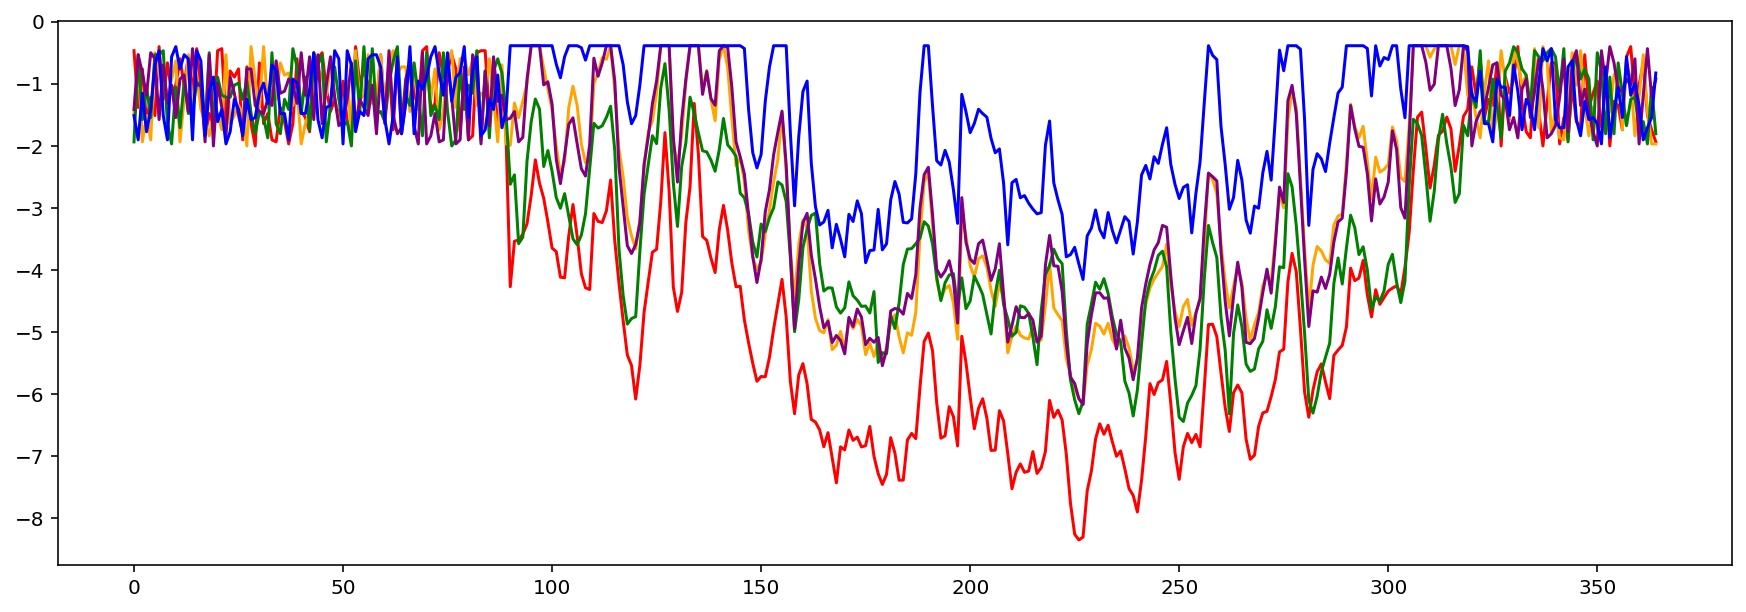

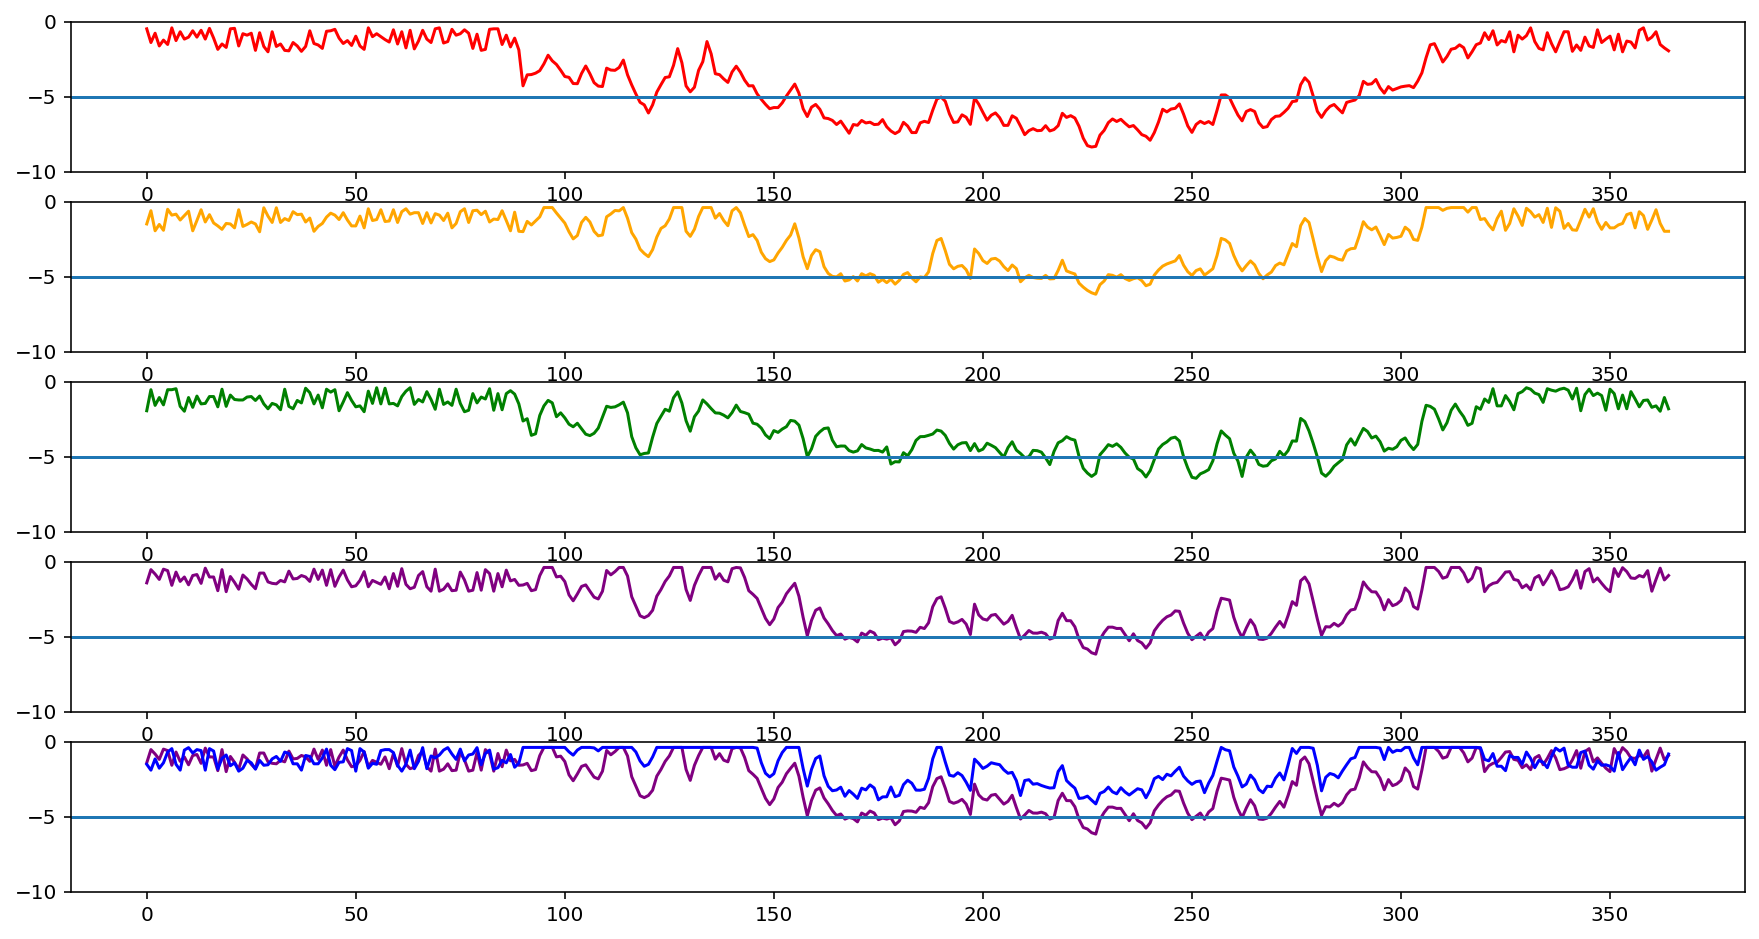

In [23]:
np.random.seed(1234)

# get site-specific water potential 
desert2015_psi    = reg.intercept_ + desert2015.iloc[:,3:5].mean(axis=1)    * reg.coef_[0] + desert2015.iloc[:,2]    * reg.coef_[1]
scrubland2015_psi = reg.intercept_ + scrubland2015.iloc[:,3:5].mean(axis=1) * reg.coef_[0] + scrubland2015.iloc[:,2] * reg.coef_[1]
grassland2015_psi = reg.intercept_ + grassland2015.iloc[:,3:5].mean(axis=1) * reg.coef_[0] + grassland2015.iloc[:,2] * reg.coef_[1]
pineoak2015_psi   = reg.intercept_ + pineoak2015.iloc[:,3:5].mean(axis=1)   * reg.coef_[0] + pineoak2015.iloc[:,2]   * reg.coef_[1]
subalpine2015_psi = reg.intercept_ + subalpine2015.iloc[:,3:5].mean(axis=1) * reg.coef_[0] + subalpine2015.iloc[:,2] * reg.coef_[1]
#subalpine_psi = subalpine_psi*0.8

desert2015_psi[desert2015_psi>max_psi]       = max_psi
scrubland2015_psi[scrubland2015_psi>max_psi] = max_psi
grassland2015_psi[grassland2015_psi>max_psi] = max_psi
pineoak2015_psi[pineoak2015_psi>max_psi]     = max_psi
subalpine2015_psi[subalpine2015_psi>max_psi] = max_psi

desert2015_psi    = desert2015_psi*0.8
scrubland2015_psi = scrubland2015_psi*0.8
grassland2015_psi = grassland2015_psi*0.8
pineoak2015_psi   = pineoak2015_psi*0.8
subalpine2015_psi = subalpine2015_psi*0.8

de=90
desert2015_psi[0*365:0*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
desert2015_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# desert2015_psi[1*365:1*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
# desert2015_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# desert2015_psi[2*365:2*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
# desert2015_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# desert2015_psi[3*365:3*365+de]       = np.random.choice(np.linspace(-2,-0.4),de)
# desert2015_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)

sc=90
scrubland2015_psi[0*365:0*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
scrubland2015_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# scrubland2015_psi[1*365:1*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
# scrubland2015_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# scrubland2015_psi[2*365:2*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
# scrubland2015_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# scrubland2015_psi[3*365:3*365+sc]       = np.random.choice(np.linspace(-2,-0.4),de)
# scrubland2015_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)

gr=90
grassland2015_psi[0*365:0*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
grassland2015_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# grassland2015_psi[1*365:1*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
# grassland2015_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# grassland2015_psi[2*365:2*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
# grassland2015_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# grassland2015_psi[3*365:3*365+gr]       = np.random.choice(np.linspace(-2,-0.4),de)
# grassland2015_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)


pi=90
pineoak2015_psi[0*365:0*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
pineoak2015_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# pineoak2015_psi[1*365:1*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
# pineoak2015_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# pineoak2015_psi[2*365:2*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
# pineoak2015_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# pineoak2015_psi[3*365:3*365+pi]       = np.random.choice(np.linspace(-2,-0.4),de)
# pineoak2015_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)

su=90
subalpine2015_psi[0*365:0*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
subalpine2015_psi[0*365+289+30:1*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# subalpine2015_psi[1*365:1*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
# subalpine2015_psi[1*365+289+30:2*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# subalpine2015_psi[2*365:2*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
# subalpine2015_psi[2*365+289+30:3*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)
# subalpine2015_psi[3*365:3*365+su]       = np.random.choice(np.linspace(-2,-0.4),de)
# subalpine2015_psi[3*365+289+30:4*365]   = np.random.choice(np.linspace(-2,-0.4),365-319)


fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(desert2015_psi,   c='red')
ax.plot(scrubland2015_psi,c='orange')
ax.plot(grassland2015_psi,c='green')
ax.plot(pineoak2015_psi,  c='purple')
ax.plot(subalpine2015_psi,c='blue')


fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(15,8))
ax1.plot(desert2015_psi,   c='red')
ax1.set_ylim(-10,0)
ax1.axhline(y=-5)

ax2.plot(scrubland2015_psi,c='orange')
ax2.set_ylim(-10,0)
ax2.axhline(y=-5)

ax3.plot(grassland2015_psi,c='green')
ax3.set_ylim(-10,0)
ax3.axhline(y=-5)

ax4.plot(pineoak2015_psi,  c='purple')
ax4.set_ylim(-10,0)
ax4.axhline(y=-5)

ax5.plot(pineoak2015_psi,  c='purple')
ax5.plot(subalpine2015_psi,c='blue')
ax5.set_ylim(-10,0)
ax5.axhline(y=-5)

plt.show()

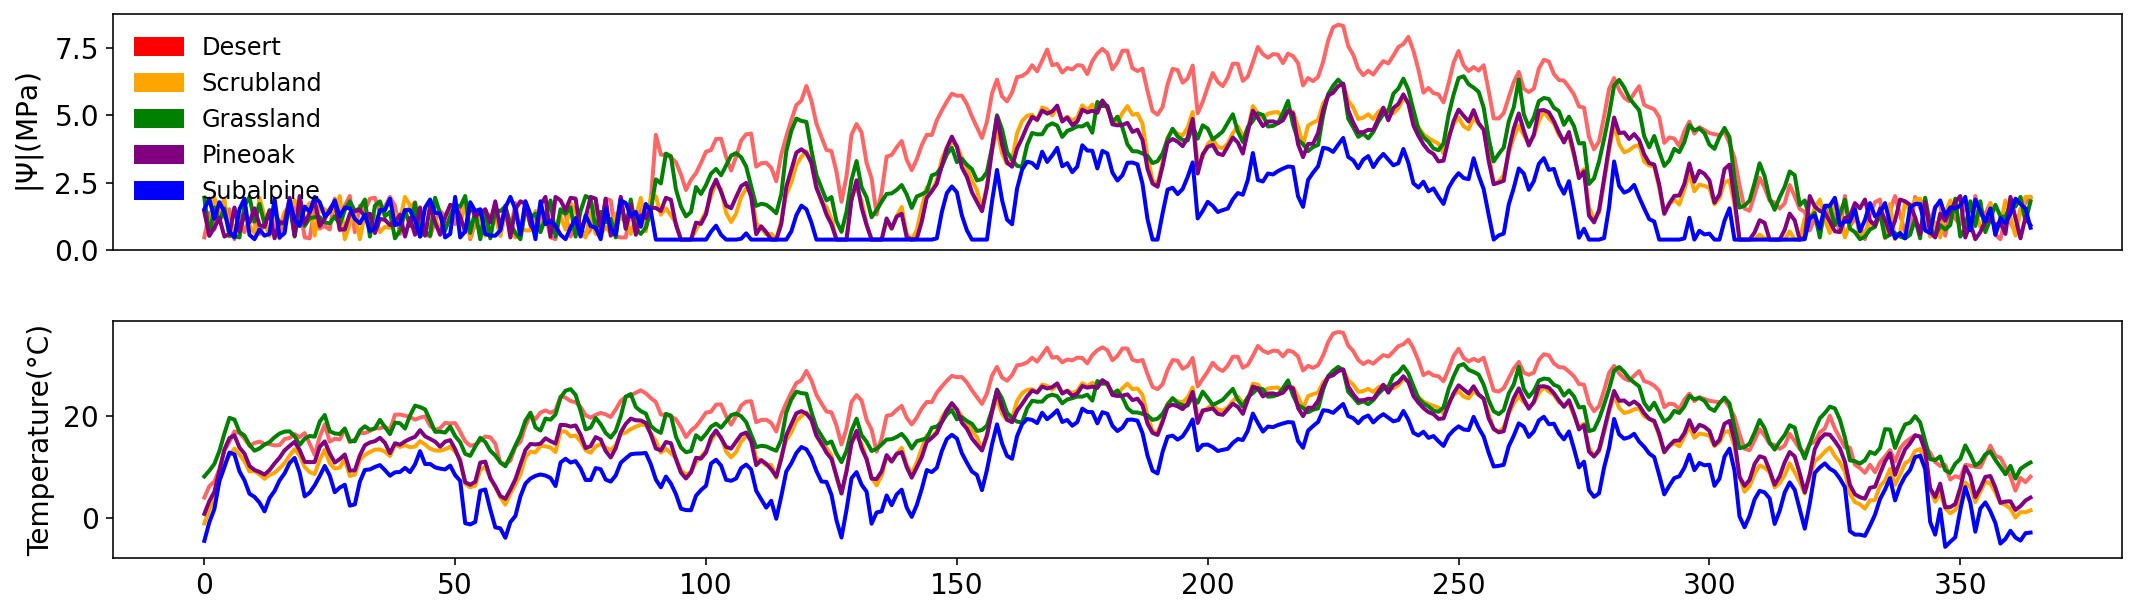

In [24]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,5))

#months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan']
# months = ['Jan', 'Mar', 'May', 'Jul',  'Sep',  'Nov', 'Jan']*4
# plt.xticks(np.linspace(365,365*5,7*4), months)
# year =[2016,2017,2018,2019,2020]
# plt.xticks(np.linspace(365,365*5,5), year)

#water potential
ax1.plot(abs(desert2015_psi),color='red',linewidth=2,alpha=0.6)
ax1.plot(abs(scrubland2015_psi),color='orange',linewidth=2)
ax1.plot(abs(grassland2015_psi),color='green',linewidth=2)
ax1.plot(abs(pineoak2015_psi),color='purple',linewidth=2)
ax1.plot(abs(subalpine2015_psi),color='blue',linewidth=2)
ax1.set_ylabel('|$\Psi$|(MPa)',size=14)
#ax1.set_xlim(-10,365+10)
ax1.tick_params(bottom=False,labelbottom=False,labelsize=14)

#legend
red_patch    = mpatches.Patch(color='red',label='Desert')
orange_patch = mpatches.Patch(color='orange',label='Scrubland')
green_patch  = mpatches.Patch(color='green',label='Grassland')
purple_patch = mpatches.Patch(color='purple',label='Pineoak')
blue_patch   = mpatches.Patch(color='blue',label='Subalpine')
ax1.legend(handles=[red_patch,orange_patch, green_patch,purple_patch,blue_patch],fontsize=12,frameon=False)

#temperature
ax2.plot(desert2015_temp,color='red',linewidth=2,alpha=0.6)    
ax2.plot(scrubland2015_temp,color='orange',linewidth=2)
ax2.plot(grassland2015_temp,color='green',linewidth=2)
ax2.plot(pineoak2015_temp,  color='purple',linewidth=2)
ax2.plot(subalpine2015_temp,color='blue',linewidth=2)
ax2.set_ylabel('Temperature(\u00B0C)',size=14)
#ax2.set_xlim(-10,365+10)
ax2.tick_params(bottom=True,labelbottom=True, labelsize=14)    
#ax2.axhline(y=20.0, linewidth=2,color='grey',linestyle=":")
#ax2.axhline(y=30.0, linewidth=2,color='grey',linestyle=":")


plt.subplots_adjust(hspace=0.3)

#plt.savefig('figures/gradient_forcing.pdf',bbox_inches='tight')

plt.show()

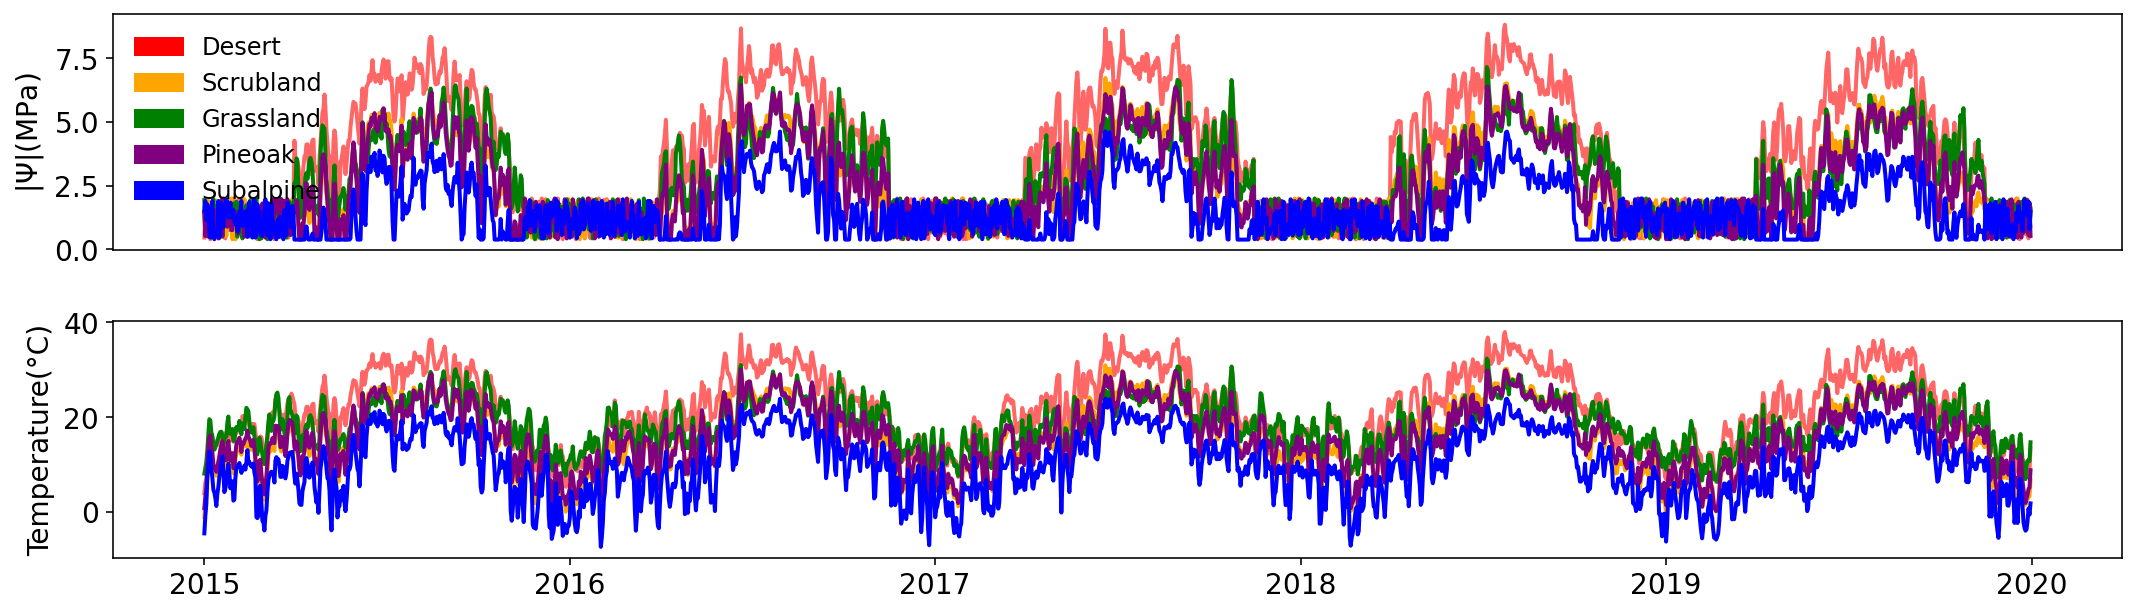

In [45]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,5))

#months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan']
# months = ['Jan', 'Mar', 'May', 'Jul',  'Sep',  'Nov', 'Jan']*4
# plt.xticks(np.linspace(365,365*5,7*4), months)
year =[2015,2016,2017,2018,2019,2020]
plt.xticks(np.linspace(0,365*5,6), year)

#water potential
ax1.plot(np.concatenate((abs(desert2015_psi),abs(desert_psi))),      color='red',linewidth=2,alpha=0.6)
ax1.plot(np.concatenate((abs(scrubland2015_psi),abs(scrubland_psi))),color='orange',linewidth=2)
ax1.plot(np.concatenate((abs(grassland2015_psi),abs(grassland_psi))),color='green',linewidth=2)
ax1.plot(np.concatenate((abs(pineoak2015_psi),abs(pineoak_psi)))    ,color='purple',linewidth=2)
ax1.plot(np.concatenate((abs(subalpine2015_psi),abs(subalpine_psi))),color='blue',linewidth=2)
ax1.set_ylabel('|$\Psi$|(MPa)',size=14)
#ax1.set_xlim(-10,365+10)
ax1.tick_params(bottom=False,labelbottom=False,labelsize=14)

#legend
red_patch    = mpatches.Patch(color='red',label='Desert')
orange_patch = mpatches.Patch(color='orange',label='Scrubland')
green_patch  = mpatches.Patch(color='green',label='Grassland')
purple_patch = mpatches.Patch(color='purple',label='Pineoak')
blue_patch   = mpatches.Patch(color='blue',label='Subalpine')
ax1.legend(handles=[red_patch,orange_patch, green_patch,purple_patch,blue_patch],fontsize=12,frameon=False)

#temperature
ax2.plot(np.concatenate((desert2015_temp,desert_temp)),color='red',linewidth=2,alpha=0.6)    
ax2.plot(np.concatenate((scrubland2015_temp,scrubland_temp)),color='orange',linewidth=2)
ax2.plot(np.concatenate((grassland2015_temp,grassland_temp)),color='green',linewidth=2)
ax2.plot(np.concatenate((pineoak2015_temp,pineoak_temp)),color='purple',linewidth=2)
ax2.plot(np.concatenate((subalpine2015_temp,subalpine_temp)),color='blue',linewidth=2)
ax2.set_ylabel('Temperature(\u00B0C)',size=14)
#ax2.set_xlim(-10,365+10)
ax2.tick_params(bottom=True,labelbottom=True, labelsize=14)    
#ax2.axhline(y=20.0, linewidth=2,color='grey',linestyle=":")
#ax2.axhline(y=30.0, linewidth=2,color='grey',linestyle=":")


plt.subplots_adjust(hspace=0.3)

plt.savefig('figures/actual_forcing.pdf',bbox_inches='tight')

plt.show()

### Create forcing for each site using a function "site_climate()"

In [20]:
def site_climate(site, temp, psi):
    
    site_climate = pd.concat([pd.Series(temp.tolist()), pd.Series(psi.tolist())], axis=1, ignore_index=False, sort=False)
    site_climate.columns = ['Temp', 'Psi']
    
    site_climate.to_csv("../"+site+"/climate.csv")

## 2016-2019

In [28]:
site_climate('desert',    desert_temp,    desert_psi)
site_climate('scrubland', scrubland_temp, scrubland_psi)
site_climate('grassland', grassland_temp, grassland_psi)
site_climate('pineoak',   pineoak_temp,   pineoak_psi)
site_climate('subalpine', subalpine_temp, subalpine_psi)

## 2015

In [21]:
site_climate('desert',    desert2015_temp,    desert2015_psi)
site_climate('scrubland', scrubland2015_temp, scrubland2015_psi)
site_climate('grassland', grassland2015_temp, grassland2015_psi)
site_climate('pineoak',   pineoak2015_temp,   pineoak2015_psi)
site_climate('subalpine', subalpine2015_temp, subalpine2015_psi)